<a href="https://colab.research.google.com/github/indrajitrdas/StreetViewNumberRecognition/blob/master/StreetViewHouseNumbers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Importing Required Libraries

In [0]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras import optimizers
from keras import regularizers
from keras import metrics
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
plt.rcParams['figure.figsize'] = (8,8)
%matplotlib inline

# Data Preprocessing

In [0]:
# Loading .mat files
train = scipy.io.loadmat('/content/gdrive/My Drive/Datasets/StreetViewHouseNumbers/train_32x32.mat')
test = scipy.io.loadmat('/content/gdrive/My Drive/Datasets/StreetViewHouseNumbers/test_32x32.mat')

In [0]:
# Splitting into Train and Test
X_train = train['X']
Y_train = train['y']
X_test = test['X']
Y_test = test['y']

In [114]:
# Shape of Train and Test
print("Shape of X_train = ", X_train.shape)
print("Shape of X_test = ", X_test.shape)
print("Shape of Y_train = ", Y_train.shape)
print("Shape of Y_test = ", Y_test.shape)

Shape of X_train =  (32, 32, 3, 73257)
Shape of X_test =  (32, 32, 3, 26032)
Shape of Y_train =  (73257, 1)
Shape of Y_test =  (26032, 1)


In [115]:
# Reshaping X_train and X_test
# Present Format : (ht(0), wd(1), channels(2), sampleIndex(3))
# New Format : (sampleIndex(3), ht(0), wd(1), channels(2))
X_train = X_train.transpose((3,0,1,2))
X_test = X_test.transpose((3,0,1,2))
Y_train = Y_train[:,0]
Y_test = Y_test[:,0]
print("New Shape of X_train = ", X_train.shape)
print("New Shape of X_test = ", X_test.shape)
print("New Shape of Y_train = ", Y_train.shape)
print("New Shape of Y_test = ", Y_test.shape)

New Shape of X_train =  (73257, 32, 32, 3)
New Shape of X_test =  (26032, 32, 32, 3)
New Shape of Y_train =  (73257,)
New Shape of Y_test =  (26032,)


In [116]:
# Unique Classes
np.unique(Y_train)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [0]:
# We notice that there are 10 classes. We also notice that images with number 0 is represented as class 10
Y_train[Y_train == 10] = 0
Y_test[Y_test == 10] = 0

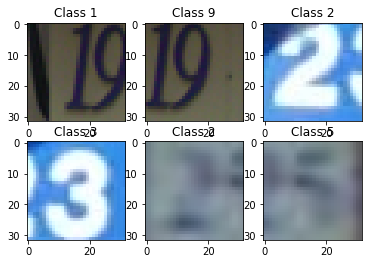

In [0]:
# Some sample images from training set
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X_train[i], interpolation='none', cmap="Greys")
    plt.title("Class {}".format(Y_train[i]))

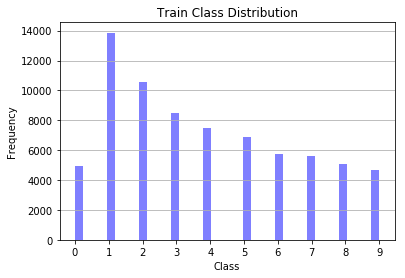

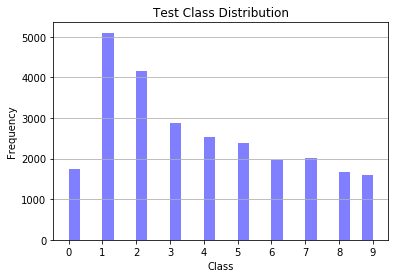

In [0]:
# Class Distribution For Training Set
bin_edges = [0,1,2,3,4,5,6,7,8,9]
plt.hist(Y_train, bins='auto', color='b', alpha=0.5, rwidth=1.5) 
plt.grid(axis='y')
plt.xlabel('Class')
plt.xticks(bin_edges)
plt.ylabel('Frequency')
plt.title("Train Class Distribution") 
plt.show()

plt.hist(Y_test, bins='auto', color='b', alpha=0.5, rwidth=1.5) 
plt.grid(axis='y')
plt.xlabel('Class')
plt.xticks(bin_edges)
plt.ylabel('Frequency')
plt.title("Test Class Distribution") 
plt.show()

In [0]:
# Converting RGB to Grayscale
def rgb2gray(images):
    return np.expand_dims(np.dot(images, [0.2990, 0.5870, 0.1140]), axis=3)
  
X_train = rgb2gray(X_train).astype(np.float32)
X_test = rgb2gray(X_test).astype(np.float32)

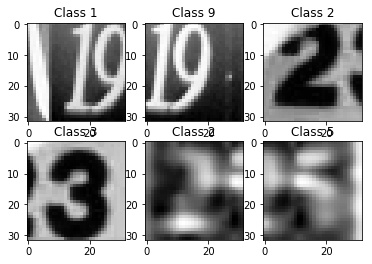

In [0]:
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X_train[i,:,:,0], interpolation='none', cmap="Greys")
    plt.title("Class {}".format(Y_train[i]))

In [0]:
# Creating Validation Set from Training Set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15) 

In [0]:
print("Shape of X_train = ", X_train.shape)
print("Shape of X_val = ", X_val.shape)
print("Shape of X_test = ", X_test.shape)
print("Shape of Y_train = ", Y_train.shape)
print("Shape of Y_val = ", Y_val.shape)
print("Shape of Y_test = ", Y_test.shape)

Shape of X_train =  (62268, 32, 32, 1)
Shape of X_val =  (10989, 32, 32, 1)
Shape of X_test =  (26032, 32, 32, 1)
Shape of Y_train =  (62268, 10)
Shape of Y_val =  (10989, 10)
Shape of Y_test =  (26032, 10)


In [0]:
# One Hot Encoding of Labels
n_classes = 10
Y_train = np_utils.to_categorical(Y_train, n_classes)
Y_val = np_utils.to_categorical(Y_val, n_classes)
#Y_test = np_utils.to_categorical(Y_test, n_classes)

In [0]:
print("Shape of Y_train = ", Y_train.shape)
print("Shape of Y_val = ", Y_val.shape)
print("Shape of Y_test = ", Y_test.shape)

Shape of Y_train =  (62268, 10)
Shape of Y_val =  (10989, 10)
Shape of Y_test =  (26032, 10)


# Model 
1. CNN
2. Logistic Regression

**1. Convolutional Neural Network : **

In [96]:
# Hyperparameters
numClasses = 10
inputDim = (32,32,1)
batchsize = 128
epochs=50
lr = 1e-4

# Model
model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape = inputDim))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, kernel_regularizer=regularizers.l2(0.01), activation = "relu"))
model.add(Dropout(0.25))

model.add(Dense(512, kernel_regularizer=regularizers.l2(0.01), activation = "relu"))
model.add(Dropout(0.25))

model.add(Dense(numClasses, activation = "softmax"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 32, 32, 64)        640       
_________________________________________________________________
batch_normalization_35 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_67 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
batch_normalization_36 (Batc (None, 16, 16, 128)       512       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 8, 8, 128)         0         
__________

In [99]:
# Model Compile
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=[metrics.categorical_accuracy])

# Image Augmentation
datagen = ImageDataGenerator(rotation_range=20, 
                         zoom_range=0.15,
                         width_shift_range=0.2, 
                         height_shift_range=0.2, 
                         shear_range=0.15,
                         horizontal_flip=True, 
                         fill_mode="nearest")

# Normalizing Input
X_train /= 255
X_val /= 255
X_test /= 255

history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batchsize),
                              validation_data=(X_val, Y_val), 
                              steps_per_epoch=len(X_train) // batchsize,
                              epochs=epochs)

Epoch 1/50
486/486 [==============================] - 37s 77ms/step - loss: 6.8349 - categorical_accuracy: 0.2121 - val_loss: 4.2106 - val_categorical_accuracy: 0.2412
Epoch 2/50
486/486 [==============================] - 31s 64ms/step - loss: 3.2699 - categorical_accuracy: 0.3133 - val_loss: 2.3603 - val_categorical_accuracy: 0.4831
Epoch 3/50
486/486 [==============================] - 31s 64ms/step - loss: 2.4075 - categorical_accuracy: 0.3845 - val_loss: 1.6746 - val_categorical_accuracy: 0.5959
Epoch 4/50
486/486 [==============================] - 32s 66ms/step - loss: 1.9533 - categorical_accuracy: 0.4664 - val_loss: 1.2969 - val_categorical_accuracy: 0.6822
Epoch 5/50
486/486 [==============================] - 31s 64ms/step - loss: 1.6735 - categorical_accuracy: 0.5281 - val_loss: 1.0607 - val_categorical_accuracy: 0.7324
Epoch 6/50
486/486 [==============================] - 31s 64ms/step - loss: 1.4864 - categorical_accuracy: 0.5786 - val_loss: 0.9473 - val_categorical_accuracy:

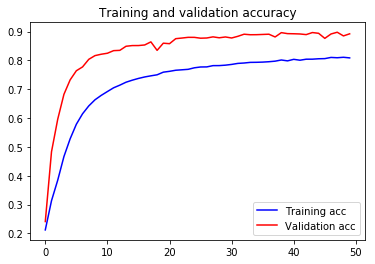

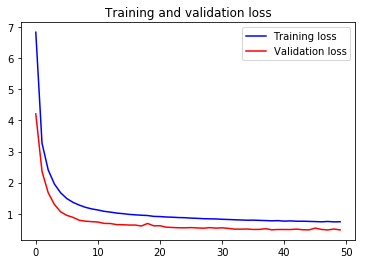

In [100]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [104]:
# Evaluation on Test Set
scores=model.evaluate(x=X_test, y=Y_test, batch_size=batchsize, verbose=1)
print(model.metrics_names)
print(scores)

26032/26032 [==============================] - 2s 87us/step
['loss', 'categorical_accuracy']
[0.4432700958146445, 0.9091118622866597]


In [0]:
# Confusion Matrix
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

Confusion Matrix


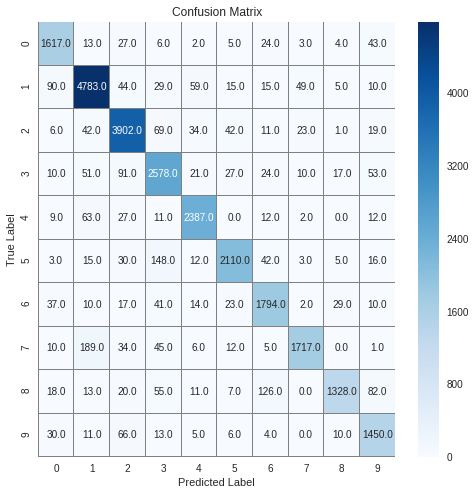

In [125]:
print('Confusion Matrix')
confusionmatrix = confusion_matrix(Y_test, y_pred)
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusionmatrix, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [126]:
print('Classification Report')
print(classification_report(Y_test, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      1744
           1       0.92      0.94      0.93      5099
           2       0.92      0.94      0.93      4149
           3       0.86      0.89      0.88      2882
           4       0.94      0.95      0.94      2523
           5       0.94      0.89      0.91      2384
           6       0.87      0.91      0.89      1977
           7       0.95      0.85      0.90      2019
           8       0.95      0.80      0.87      1660
           9       0.85      0.91      0.88      1595

   micro avg       0.91      0.91      0.91     26032
   macro avg       0.91      0.90      0.90     26032
weighted avg       0.91      0.91      0.91     26032

